In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import pandas as pd
import h5py
import sys
import os
import glob
import warnings
import matplotlib.pyplot as plt

from tqdm import tqdm

basedir = '/project/vitelli/jonathan/REDO_fruitfly/'
sys.path.insert(0, os.path.join(basedir, 'src'))

# New Cadherin Pullbacks

Text(0.5, 0.98, 'Embryo202001281430')

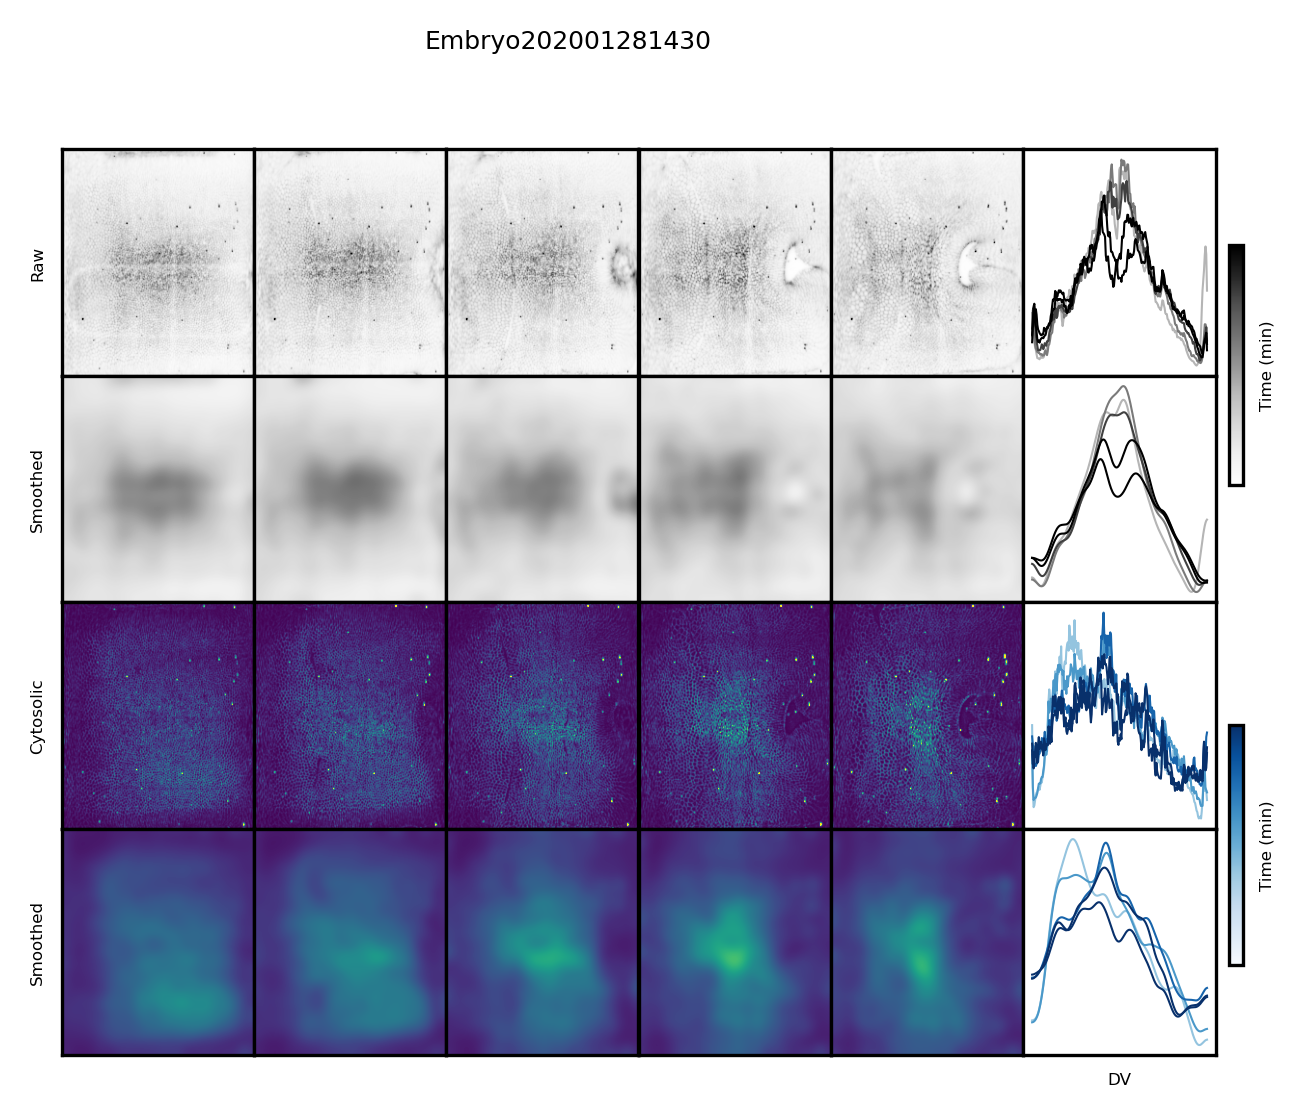

In [8]:
from utils.plot_utils import *
from scipy.ndimage import gaussian_filter, median_filter

#eId = '202001282000'
#eId = '202001281800'
eId = '202001281430'
#eId = '202001271040'
raw = np.load('../Public/WT/ECad-GFP/'+eId+'/raw2D.npy', mmap_mode='r')
cyt = np.load('../Public/WT/ECad-GFP/'+eId+'/cyt2D.npy', mmap_mode='r')

cmin = np.min(cyt[:40])
cmax = cmin + 10 * np.std(cyt[:40])

rmin = np.min(raw[:40])
rmax = rmin + 10 * np.std(raw[:40])

fig, ax = plt.subplots(4, 6, dpi=300, figsize=(5*0.7+1, 4))
c_cyt = plt.get_cmap('Blues')
c_raw = plt.get_cmap('Greys')


offset = 20
sigma=7
for i, tt in enumerate([0, 10, 20, 30, 40]):
    color_2D(ax[0, i], raw[tt], cmap='Greys', vmin=rmin, vmax=rmax)
    c_smooth = gaussian_filter(raw[tt], sigma=sigma)
    color_2D(ax[1, i], c_smooth, cmap='Greys', vmin=rmin, vmax=rmax-3*np.std(raw[:40]))
    color_2D(ax[2, i], cyt[tt], cmap='viridis', vmin=cmin, vmax=cmax)
    c_smooth = gaussian_filter(cyt[tt], sigma=sigma)
    color_2D(ax[3, i], c_smooth, 
             cmap='viridis', vmin=cmin, vmax=cmax-5*np.std(cyt[:40]))
    
    color = c_raw((tt+offset)/50)
    ax[0, -1].plot(np.mean(raw[tt, :, 80:180], axis=-1), color=color, lw=0.5)
    csmooth = gaussian_filter(raw[tt], sigma=7)
    ax[1, -1].plot(np.mean(csmooth[:, 80:180], axis=-1), color=color, lw=0.5)
    color = c_cyt((tt+offset)/50)
    ax[2, -1].plot(np.mean(cyt[tt, :, 80:180], axis=-1), color=color, lw=0.5)
    csmooth = gaussian_filter(cyt[tt], sigma=7)
    ax[3, -1].plot(np.mean(csmooth[:, 80:180], axis=-1), color=color, lw=0.5)

plt.rcParams['axes.labelsize'] = 4
ax[0, 0].set_ylabel('Raw')
ax[1, 0].set_ylabel('Smoothed')
ax[2, 0].set_ylabel('Cytosolic')
ax[3, 0].set_ylabel('Smoothed')
for a in ax[:, :-1].flatten():
    a.set_aspect('equal')
    
for i in range(4):
    ax[i, -1].set(
        xlabel='DV', ylabel='',
        xticks=[], yticks=[])
    
fig.subplots_adjust(right=0.98, wspace=0.0, hspace=0.)
norm = Normalize(vmin=-10, vmax=50)
cax = fig.add_axes([0.99, 0.6, 0.01, 0.2])
plt.colorbar(plt.cm.ScalarMappable(norm=norm, cmap='Greys'),
             cax=cax, label='Time (min)', ticks=[])
cax = fig.add_axes([0.99, 0.2, 0.01, 0.2])
plt.colorbar(plt.cm.ScalarMappable(norm=norm, cmap='Blues'),
             cax=cax, label='Time (min)', ticks=[])
fig.suptitle('Embryo' + eId, fontsize=6)

(200, 236) (46, 54)
PIV:	 0.65475 um / pixel
Field		     Max      Min     Mean      Std (Units um / min)
---------------------------------------------------
4
    PIV Filtered   5.359    0.050    1.877    1.173
10
        Pipeline   5.365    0.006    1.885    1.205


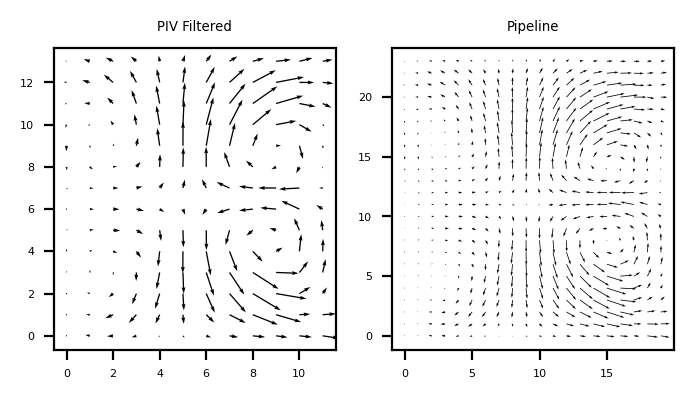

In [3]:
from scipy.io import loadmat
import matplotlib.pyplot as plt

datadir = '../../flydrive.synology.me/Public/dynamic_atlas/Atlas_Data/WT/ECad-GFP/202001280915/'
piv_filtered = loadmat(os.path.join(datadir, 'PIV_filtered', 'VeloT_medfilt_000040.mat'))
piv_filtered['VX'], piv_filtered['VY'] = piv_filtered['VY'], piv_filtered['VX']

calculated = np.load(os.path.join(datadir, 'velocity2D.npy'))[40]
calculated = {
    'VX': calculated[1].T,
    'VY': calculated[0].T
}

print(calculated['VX'].shape, piv_filtered['VX'].shape)

pixel_to_um = 0.2619
piv_rescale_factor = 0.4 / pixel_to_um

print('PIV:\t', 1/piv_rescale_factor, 'um / pixel')

plt.rcParams['font.size'] = 4
fig, ax = plt.subplots(1, 2, dpi=200, figsize=(4, 2))
ax = ax.flatten()
dct = {
    'PIV Filtered': [piv_filtered, 1/piv_rescale_factor],
    'Pipeline': [calculated, 1/piv_rescale_factor],
}

print('Field\t\t%8s %8s %8s %8s (Units um / min)' % ('Max', 'Min', 'Mean', 'Std'))
print('---------------------------------------------------')
for i, key in enumerate(dct):
    mat, conversion = dct[key]
    skip = max(2, 2 * (mat['VX'].shape[1] // piv_filtered['VX'].shape[1] + 1))
    print(skip)
    ax[i].quiver(mat['VX'][::skip, ::skip].T, mat['VY'][::skip, ::skip].T)
    
    vnorm = np.sqrt(mat['VX']**2 + mat['VY']**2) * conversion
    print('%16s%8.3f %8.3f %8.3f %8.3f' % (key, np.max(vnorm), np.min(vnorm), np.mean(vnorm), np.std(vnorm)))
    ax[i].set_title(key)

In [2]:
from scipy.io import loadmat
from atlas_processing.anisotropy_detection import *

/project/vitelli/jonathan/REDO_fruitfly/src/atlas_processing/windowed_radon.py:300: RuntimeWarning: divide by zero encountered in true_divide
  line_weights = 1/(2*np.sqrt(e_len**2-(delta)**2))


In [88]:
tiff_fn = '../Public/WT/ECad-GFP/202001271040/MAX_Cyl1_2_000000_c1_rot_scaled_view1.tif'
#tiff_fn = '../Public/Halo_Hetero_Twist[ey53]_Hetero/Sqh-GFP/202006261115/MAX_Cyl1_2_000000_c1_rot_scaled_view1.tif'
movie = Image.open(tiff_fn)
print(movie.n_frames)
raws, cyts, tensors = [], [], []
for ii in tqdm(range(movie.n_frames)):
    movie.seek(ii)
    raw = np.array(movie)

    threshold = raw.mean() + 10 * np.std(raw)
    raw[raw > threshold] = threshold #median_filter(raw, size=8*cell_size)[raw > threshold]

    cyt = cytosolic_normalize(raw)
    #tensor = anisotropy_tensor(cyt)
    
    raws.append(raw)
    cyts.append(cyt)
    tensors.append(tensor)
raws = np.stack(raws)
cyts = np.stack(cyts)
tensors = np.stack(tensors)

raws_rescale = resize(raws, (raws.shape[0], 236, 200))
cyts_rescale = resize(cyts, (cyts.shape[0], 236, 200))

79


100%|██████████| 79/79 [02:43<00:00,  2.07s/it]


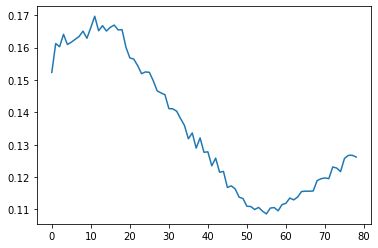

7703 24


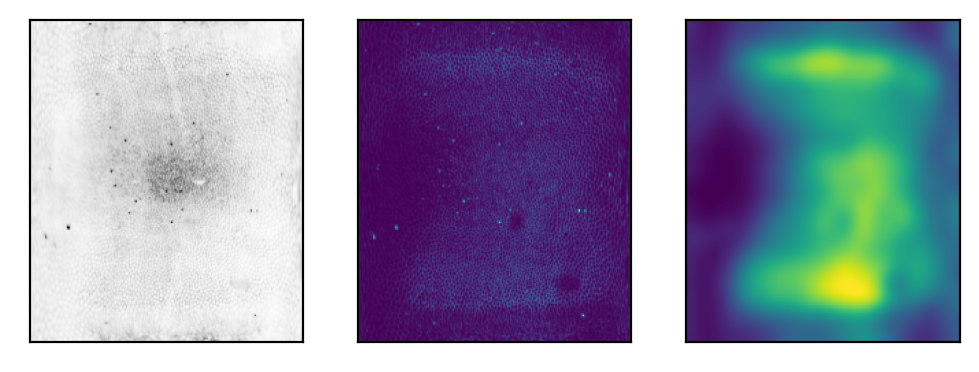

In [96]:
import matplotlib.pyplot as plt
from utils.plot_utils import *
from scipy.ndimage import gaussian_filter, median_filter
fig, ax = plt.subplots(1, 3, dpi=200)

print(np.max(raw), np.min(raw))

tt = 5
color_2D(ax[0], raws_rescale[tt], cmap='Greys')
color_2D(ax[1], cyts_rescale[tt], cmap='viridis')
color_2D(ax[2], gaussian_filter(cyts_rescale[tt], sigma=cell_size), cmap='viridis')

for a in ax:
    a.set(xticks=[], yticks=[])

# Looking at the flydrive/Public/dynamic_atlas dataset

In [187]:
#Coordinate systems
from scipy.io import loadmat
from plyfile import PlyData

atlas_dir = '/project/vitelli/jonathan/REDO_fruitfly/flydrive.synology.me/Public/dynamic_atlas'
geometry_dir = os.path.join(atlas_dir, 'embryo_geometry')
piv_scale = loadmat(os.path.join(geometry_dir, 'embryo_rectPIVscale_fundamentalForms.mat'))
pix_scale = loadmat(os.path.join(atlas_dir, '../../minimalData/vitelli_sharing', 'pixel_coordinates.mat'))
rect_piv_scale = PlyData.read(os.path.join(geometry_dir, 'rect_PIVImageScale.ply'))
print(rect_piv_scale['vertex']['x'])
piv_rescale = 0.4
um_per_pix = 0.2619
X0, Y0 = piv_scale['X0'], piv_scale['Y0']
XX, YY = pix_scale['XX'], pix_scale['YY']

xmin, xmax = np.min(rect_piv_scale['vertex']['x']), np.max(rect_piv_scale['vertex']['x'])
ymin, ymax = np.min(rect_piv_scale['vertex']['y']), np.max(rect_piv_scale['vertex']['y'])

print(xmin, xmax, ymin, ymax)

nAP = 200
nDV = 236
ap_space = np.linspace(xmin+xmax/nAP*0.5, xmax-xmin/nAP*0.5, nAP)
dv_space = np.linspace(ymin+ymax/nDV*0.5, ymax-ymin/nDV*0.5, nDV)

dv_space, ap_space = np.meshgrid(dv_space, ap_space, indexing='ij')

dv2 = np.load('../../flydrive.synology.me/Public/dynamic_atlas/Atlas_Data/WT/ECad-GFP/202001261800/DV_coordinates.npy')
ap2 = np.load('../../flydrive.synology.me/Public/dynamic_atlas/Atlas_Data/WT/ECad-GFP/202001261800/AP_coordinates.npy')
convert = um_per_pix / piv_rescale
dv2, ap2 = dv2 / convert, ap2 / convert

#In units of pixels
print('\nUNITS = PIV scale pixels')
for x, y in [(X0, Y0), (ap_space, dv_space), (XX, YY), (ap2, dv2)]:
    print('%8.3f %8.3f %8.3f %8.3f' % (np.min(x), np.max(x), np.min(y), np.max(y)), x.shape, y.shape)

print('\nUNITS = Image scale pixels')
for x, y in [(X0, Y0), (ap_space, dv_space), (XX, YY), (ap2, dv2)]:
    x, y = x / piv_rescale, y / piv_rescale
    print('%8.3f %8.3f %8.3f %8.3f' % (np.min(x), np.max(x), np.min(y), np.max(y)), x.shape, y.shape)

print('\nUNITS = microns')
for x, y in [(X0, Y0), (ap_space, dv_space), (XX, YY), (ap2, dv2)]:
    x, y = x * um_per_pix / piv_rescale, y * um_per_pix / piv_rescale
    print('%8.3f %8.3f %8.3f %8.3f' % (np.min(x), np.max(x), np.min(y), np.max(y)), x.shape, y.shape)


[696.    696.    696.    ...   3.193   3.193   3.193]
3.192661 696.0 3.190661 820.0

UNITS = PIV scale pixels
   7.500  682.500    7.500  802.500 (54, 46) (54, 46)
   4.933  695.992    4.928  819.993 (236, 200) (236, 200)
   4.933  694.260    4.928  818.263 (236, 200) (236, 200)
   4.933  695.992    4.928  819.993 (236, 200) (236, 200)

UNITS = Image scale pixels
  18.750 1706.250   18.750 2006.250 (54, 46) (54, 46)
  12.332 1739.980   12.320 2049.983 (236, 200) (236, 200)
  12.332 1735.650   12.320 2045.657 (236, 200) (236, 200)
  12.332 1739.980   12.320 2049.983 (236, 200) (236, 200)

UNITS = microns
   4.911  446.867    4.911  525.437 (54, 46) (54, 46)
   3.230  455.701    3.227  536.891 (236, 200) (236, 200)
   3.230  454.567    3.227  535.758 (236, 200) (236, 200)
   3.230  455.701    3.227  536.891 (236, 200) (236, 200)


(46, 54) (46, 54)
PIV:	 0.65475 um / pixel
PIV Lab: 0.65475 um / pixel
Field		     Max      Min     Mean      Std (Units um / min)
---------------------------------------------------
    PIV Filtered   6.960    0.000    1.908    1.455
        Pipeline   6.960    0.000    1.908    1.455
 PIVlab Filtered  13.708    0.017    3.252    2.661
          PIVlab  16.056    0.011    3.525    2.883


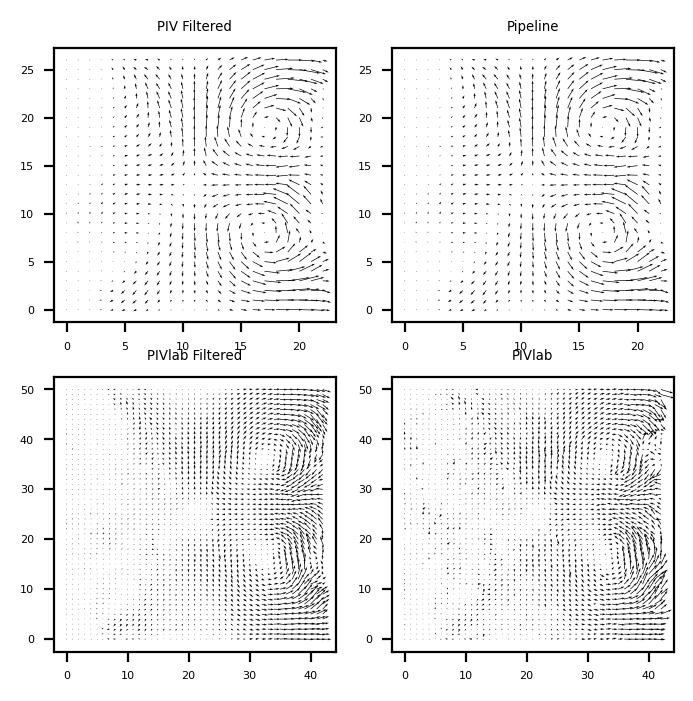

In [40]:
from scipy.io import loadmat
import matplotlib.pyplot as plt

datadir = '../../flydrive.synology.me/Public/dynamic_atlas/Atlas_Data/Halo_Hetero_Twist[ey53]_Hetero/Sqh-GFP/202007011145'
piv_filtered = loadmat(os.path.join(datadir, 'PIV_filtered', 'VeloT_medfilt_000040.mat'))
piv_filtered['VX'], piv_filtered['VY'] = piv_filtered['VY'], piv_filtered['VX']
pivlab_filtered = loadmat(os.path.join(datadir, 'PIVlab_filtered', 'VeloT_medfilt_fine_000040.mat'))
pivlab = loadmat(os.path.join(datadir, 'PIVlab', 'VeloT_fine_000040.mat'))

datadir = '../../flydrive.synology.me/minimalData/Atlas_Data/WT/sqh-GFP_twistPlus/202007011145/'
calculated = loadmat(os.path.join(datadir, 'PIV_filtered', 'VeloT_medfilt_000040.mat'))
calculated['VX'], calculated['VY'] = calculated['VY'], calculated['VX']

print(calculated['VX'].shape, piv_filtered['VX'].shape)

pixel_to_um = 0.2619
piv_rescale_factor = 0.4 / pixel_to_um
convert_pivlab_to_um_per_min = pivlab['convert_to_um_per_min'][0][0]

print('PIV:\t', 1/piv_rescale_factor, 'um / pixel')
print('PIV Lab:', convert_pivlab_to_um_per_min, 'um / pixel')

skip= pivlab['VX'].shape[1] // piv_filtered['VX'].shape[1] + 1
plt.rcParams['font.size'] = 4
fig, ax = plt.subplots(2, 2, dpi=200, figsize=(4, 4))
ax = ax.flatten()
dct = {
    'PIV Filtered': [piv_filtered, 1/piv_rescale_factor],
    'Pipeline': [calculated, 1/piv_rescale_factor],
    'PIVlab Filtered': [pivlab_filtered, convert_pivlab_to_um_per_min],
    'PIVlab': [pivlab, convert_pivlab_to_um_per_min]
}

print('Field\t\t%8s %8s %8s %8s (Units um / min)' % ('Max', 'Min', 'Mean', 'Std'))
print('---------------------------------------------------')
for i, key in enumerate(dct):
    mat, conversion = dct[key]
    skip = max(1, mat['VX'].shape[1] // piv_filtered['VX'].shape[1]+1)
    ax[i].quiver(mat['VX'][::skip, ::skip].T, mat['VY'][::skip, ::skip].T)
    
    vnorm = np.sqrt(mat['VX']**2 + mat['VY']**2) * conversion
    print('%16s%8.3f %8.3f %8.3f %8.3f' % (key, np.max(vnorm), np.min(vnorm), np.mean(vnorm), np.std(vnorm)))
    ax[i].set_title(key)

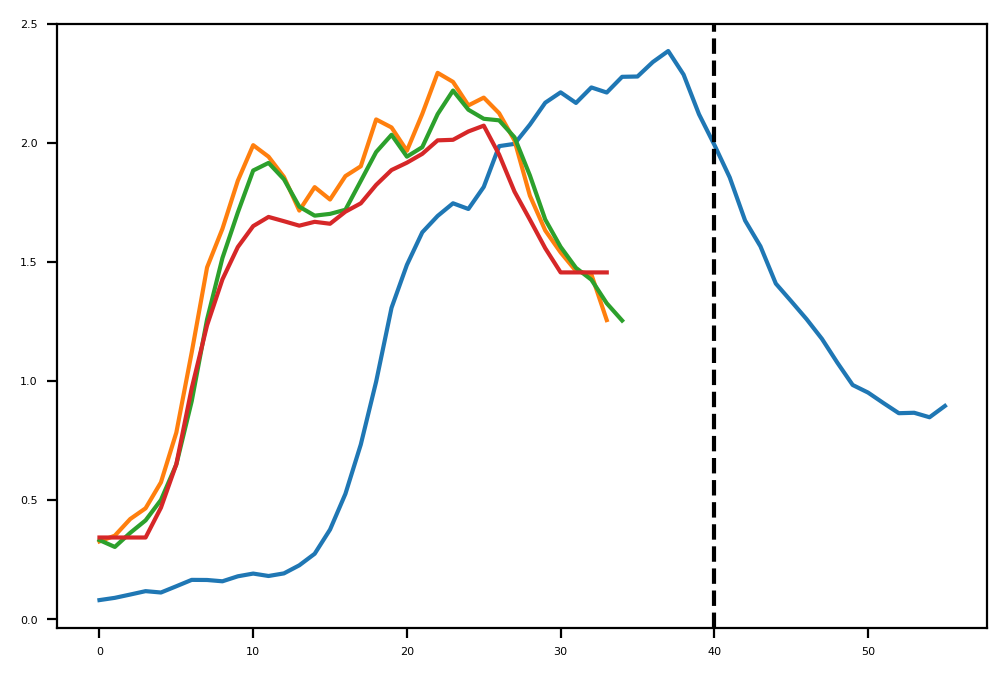

In [190]:
ens = loadmat('/project/vitelli/jonathan/REDO_fruitfly/flydrive.synology.me/minimalData/vitelli_sharing/ensemble/ensemble_velocity.mat')['velocity']
v1 = loadmat('/project/vitelli/jonathan/REDO_fruitfly/flydrive.synology.me/minimalData/vitelli_sharing/202006261115/202006261115_velocity.mat')['velocity']
v2 = loadmat('/project/vitelli/jonathan/REDO_fruitfly/flydrive.synology.me/Public/dynamic_atlas/Atlas_Data/Halo_Hetero_Twist[ey53]_Hetero/Sqh-GFP/202006261115/202006261115_velocity.mat')['velocity']

v_pipe = np.load('/project/vitelli/jonathan/REDO_fruitfly/flydrive.synology.me/minimalData/Atlas_Data/WT/sqh-GFP_twistPlus/202006261115/velocity2D.npy', mmap_mode='r')
v_pipe = np.transpose(v_pipe, (0, 2, 3, 1))
v_pipe = v_pipe

plt.figure(dpi=200)
for v in [ens, v1, v2, v_pipe]:
    vnorm = np.linalg.norm(v, axis=-1)
    vmean = np.mean(vnorm, axis=(-2, -1))
    vstd = np.std(vnorm, axis=(-2, -1))
    plt.plot(vmean)
plt.axvline(40, color='black', linestyle='--')



(34, 2, 2, 236, 200) (35, 2, 2, 236, 200)
[[ 0.498 -0.006]
 [-0.006 -0.498]]
[[ 0.05  -0.002]
 [-0.002 -0.05 ]]


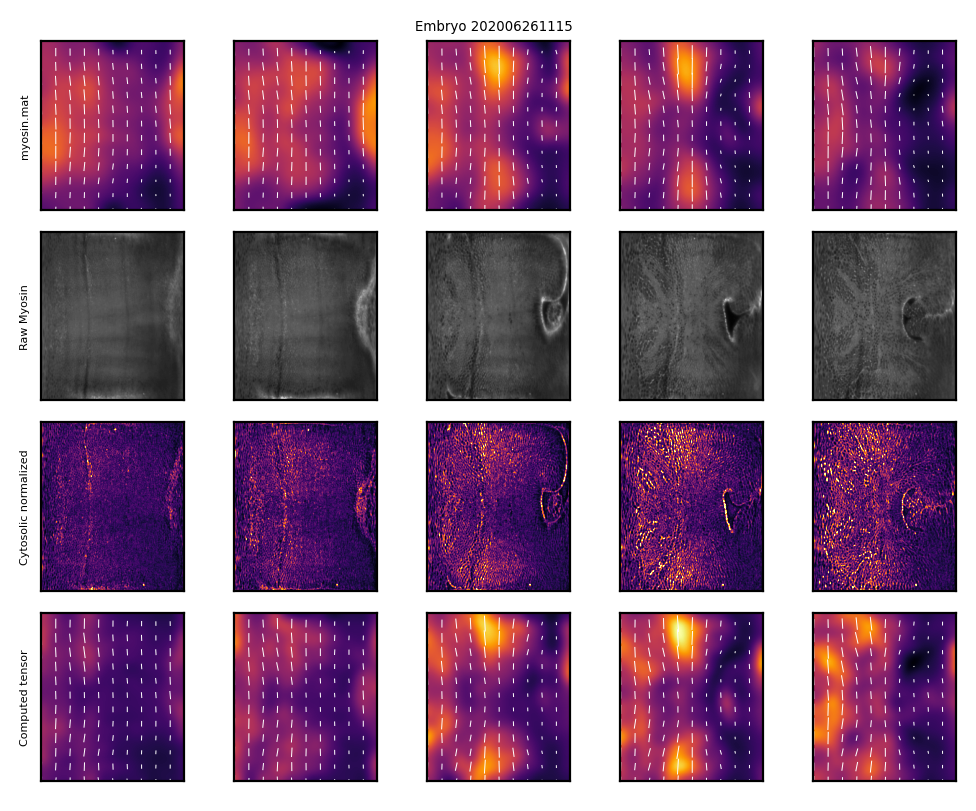

In [191]:
m = loadmat('/project/vitelli/jonathan/REDO_fruitfly/flydrive.synology.me/Public/dynamic_atlas/Atlas_Data/Halo_Hetero_Twist[ey53]_Hetero/Sqh-GFP/202006261115/202006261115_myosin.mat')
m = m['myosin']
m = np.transpose(m, (0, 3, 4, 1, 2)) #m_xx, m_xy, m_yx, m_yy
m = m.reshape([m.shape[0], -1, *m.shape[-2:]])
m[:, 1:3] *= -1
m = m[:, (3, 2, 1, 0), :, :]
m = m.reshape([m.shape[0], 2, 2, *m.shape[-2:]])

m2 = np.load('/project/vitelli/jonathan/REDO_fruitfly/flydrive.synology.me/Public/dynamic_atlas/Atlas_Data/Halo_Hetero_Twist[ey53]_Hetero/Sqh-GFP/202006261115/tensor2D.npy', mmap_mode='r')
print(m2.shape, m.shape)
trm2 = np.einsum('bkkyx->byx', m2)[:, None, None]
m2 = m2.copy() - 0.5 * np.eye(2)[None, :, :, None, None] * trm2
print(m[25, :, :, 100, 100])
print(m2[25, :, :, 100, 100])

raw = np.load('/project/vitelli/jonathan/REDO_fruitfly/flydrive.synology.me/Public/dynamic_atlas/Atlas_Data/Halo_Hetero_Twist[ey53]_Hetero/Sqh-GFP/202006261115/raw2D.npy', mmap_mode='r')
cyt = np.load('/project/vitelli/jonathan/REDO_fruitfly/flydrive.synology.me/Public/dynamic_atlas/Atlas_Data/Halo_Hetero_Twist[ey53]_Hetero/Sqh-GFP/202006261115/cyt2D.npy', mmap_mode='r')

mnorm = np.linalg.norm(m, axis=(1, 2))
vmin = np.min(mnorm)
vmax = np.max(mnorm)

m2norm = np.linalg.norm(m2, axis=(1, 2))
v2min = np.min(m2norm)
v2max = np.max(m2norm)

rmax = np.ptp(raw)
cmax = 5*np.std(cyt)

plt.rcParams['image.origin'] = 'lower'
from utils.plot_utils import *
fig, ax = plt.subplots(4, 5, figsize=(5, 4), dpi=200)
for i in range(0, 30, 7):
    plot_tensor2D(ax[0, i//7], m[i], vmin=vmin, vmax=vmax)
    color_2D(ax[1, i//7], raw[i]-np.min(raw), vmin=0, vmax=rmax, cmap='Greys_r')
    color_2D(ax[2, i//7], cyt[i]-np.min(cyt), vmin=0, vmax=cmax, cmap='inferno')
    plot_tensor2D(ax[3, i//7], m2[i], vmin=v2min, vmax=v2max)
    
fig.suptitle('Embryo 202006261115')
ax[0, 0].set_ylabel('myosin.mat')
ax[1, 0].set_ylabel('Raw Myosin')
ax[2, 0].set_ylabel('Cytosolic normalized')
ax[3, 0].set_ylabel('Computed tensor')
plt.tight_layout()

In [107]:
import sys
sys.path.insert(0, '..')
from utils.dataset import *
from torchvision.transforms import Compose
from anisotropy_detection import cell_size
transform = Reshape2DField()
sqh_dataset = AtlasDataset('Halo_Hetero_Twist[ey53]_Hetero', 'Sqh-GFP', 'tensor2D', transform=transform, drop_no_time=False)
sqh_vel_dataset = AtlasDataset('Halo_Hetero_Twist[ey53]_Hetero', 'Sqh-GFP', 'velocity2D', transform=transform, drop_no_time=False)

cad_dataset = AtlasDataset('WT', 'ECad-GFP', 'cyt2D', transform=Compose([transform, Smooth2D(sigma=cell_size)]))
cad_vel_dataset = AtlasDataset('WT', 'ECad-GFP', 'velocity2D', transform=transform)

/project/vitelli/jonathan/REDO_fruitfly/src/atlas_processing/windowed_radon.py:300: RuntimeWarning: divide by zero encountered in true_divide
  line_weights = 1/(2*np.sqrt(e_len**2-(delta)**2))
100%|██████████| 6/6 [00:00<00:00, 12.97it/s]


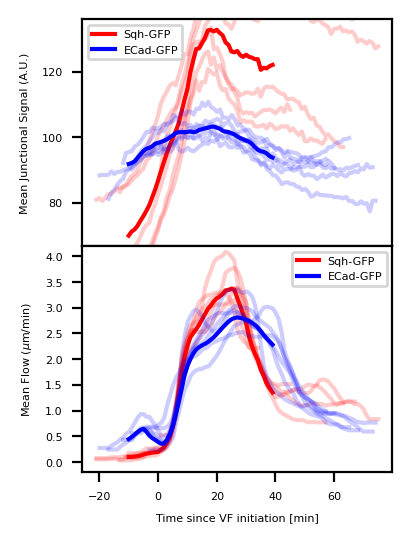

In [111]:
offsets = pd.DataFrame(columns=['embryoID', 'offset']).set_index('embryoID')

offsets.loc[202006261115, 'offset'] = -1
offsets.loc[202007011145, 'offset'] = 21
offsets.loc[202007081130, 'offset'] = 13
offsets.loc[202007091200, 'offset'] = 21
offsets.loc[202008131005, 'offset'] = 10
offsets.loc[202009041145, 'offset'] = 11
offsets.to_csv('../Public/Halo_Hetero_Twist[ey53]_Hetero/Sqh-GFP/morphodynamic_offsets.csv')

import matplotlib.pyplot as plt
fig, ax = plt.subplots(2, 1, dpi=200, figsize=(2., 3), sharex=True)
ax[0].set_ylabel('Mean Junctional Signal (A.U.)')
ax[1].set_ylabel('Mean Flow ($\\mu$m/min)')
ax[1].set_ylim([-0.2, 4.2])
#ax[1].set_xlim([-10, 40])
ax[1].set_xlabel('Time since VF initiation [min]')

ensemble_v = np.load(os.path.join('../Public/Halo_Hetero_Twist[ey53]_Hetero/Sqh-GFP/ensemble', 'velocity2D.npy'))
ensemble_m = np.load(os.path.join('../Public/Halo_Hetero_Twist[ey53]_Hetero/Sqh-GFP/ensemble', 'tensor2D.npy'))
ensemble_m = np.linalg.norm(ensemble_m, axis=(1, 2)).mean(axis=(1, 2))
ensemble_v = np.linalg.norm(ensemble_v, axis=(1)).mean(axis=(1, 2))
ensemble_t = np.load(os.path.join('../Public/Halo_Hetero_Twist[ey53]_Hetero/Sqh-GFP/ensemble', 't.npy'))
ax[0].plot(ensemble_t, ensemble_m*1e3, color='red', label='Sqh-GFP')
ax[1].plot(ensemble_t, ensemble_v, color='red', label='Sqh-GFP')
ylim = ax[0].get_ylim()

for eId in sqh_dataset.df.embryoID.unique():
    for i, dataset in enumerate([sqh_dataset, sqh_vel_dataset]):
        values = dataset.values[eId]
        time = dataset.df.loc[dataset.df.embryoID == eId, 'time']
        norm = np.linalg.norm(values.reshape([values.shape[0], -1, *values.shape[-2:]]), axis=1).mean(axis=(1, 2))
        ax[i].plot(time, norm*1e3 if i == 0 else norm, color='red', alpha=0.2)
ax[0].set_ylim(ylim)
ax[0].set_yticks([80, 100, 120])
        
offsets = pd.DataFrame(columns=['embryoID', 'offset']).set_index('embryoID')
for eId in cad_dataset.df.embryoID.unique():
    offsets.loc[eId, 'offset'] = 18
    for i, dataset in enumerate([cad_dataset, cad_vel_dataset]):
        #if i == 0: continue
        values = dataset.values[eId]
        time = dataset.df.loc[dataset.df.embryoID == eId, 'time']
        norm = np.linalg.norm(values.reshape([values.shape[0], -1, *values.shape[-2:]]), axis=1).mean(axis=(1, 2))
        ax[i].plot(time, norm*5e1 if i == 0 else norm, color='blue', alpha=0.2)

ensemble_c = np.load(os.path.join('../Public/WT/ECad-GFP/ensemble', 'cyt2D.npy')).mean(axis=(1, 2))
ensemble_v = np.load(os.path.join('../Public/WT/ECad-GFP/ensemble', 'velocity2D.npy'))
ensemble_v = np.linalg.norm(ensemble_v, axis=(1)).mean(axis=(1, 2))
ensemble_t = np.load(os.path.join('../Public/WT/ECad-GFP/ensemble', 't.npy'))
ax[0].plot(ensemble_t, ensemble_c*5e1, color='blue', label='ECad-GFP')
ax[1].plot(ensemble_t, ensemble_v, color='blue', label='ECad-GFP')

ax[0].legend()
ax[1].legend()
        
fig.subplots_adjust(hspace=0)
        
offsets.to_csv('../Public/WT/ECad-GFP/morphodynamic_offsets.csv')

# Static Atlas Interface

2.6656461866899264 0.49936659335050604 1.0390939515334092
10.23745253766664 0.043900046187254085 1.6698799441085665
1.0122004782414822 0.1363579205987994


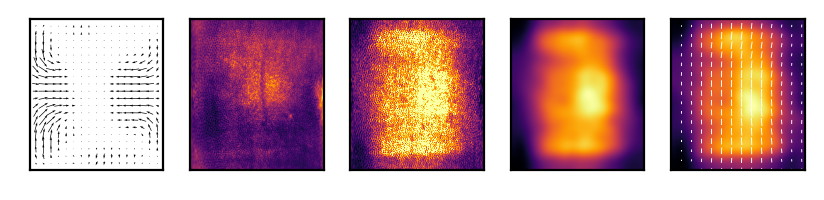

In [4]:
from utils.plot_utils import *

datadir = '../data/WT/ECad-GFP/ensemble/'


vels = np.load(os.path.join(datadir, 'velocity2D.npy'), mmap_mode='r')
raws = np.load(os.path.join(datadir, 'raw2D.npy'), mmap_mode='r')
cyts = np.load(os.path.join(datadir, 'cyt2D.npy'), mmap_mode='r')
tens = np.load(os.path.join(datadir, 'tensor2D.npy'), mmap_mode='r')
time = np.load(os.path.join(datadir, 't.npy'), mmap_mode='r')
print(np.max(raws), np.min(raws), np.median(raws))
print(np.max(cyts), np.min(cyts), np.median(cyts))
tnorm = np.linalg.norm(tens, axis=(1, 2))

from scipy.ndimage import gaussian_filter

tt = 5
tt = np.argmin(np.abs(time - tt))
print(np.max(tnorm[tt]), np.min(tnorm[tt]))
fig, ax = plt.subplots(1, 5, figsize=(5, 1), dpi=200)

plot_vector2D(ax[0], vels[tt], skip=12)
color_2D(ax[1], raws[tt], vmax_std=10)
color_2D(ax[2], cyts[tt], vmax_std=3)
color_2D(ax[3], gaussian_filter(cyts[tt], sigma=8))
plot_tensor2D(ax[4], tens[tt, :], skip=15)

for a in ax.flatten():
    a.set_aspect('auto')


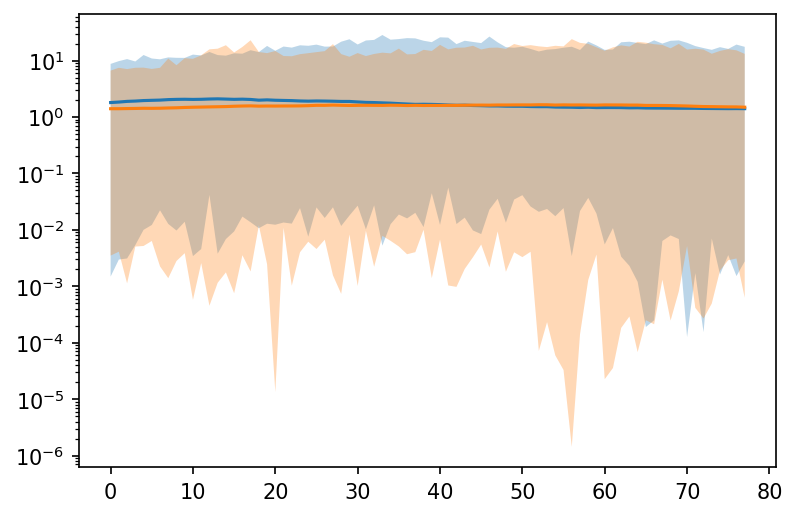

In [6]:
cads = np.load('../data/WT/ECad-GFP/202001261800/cyt2D.npy', mmap_mode='r')
myos = np.load('../data/WT/sqh-mCherry/202001261800/cyt2D.npy', mmap_mode='r')

fig, ax = plt.subplots(1, 1, dpi=150)
ax.plot(np.mean(cads, axis=(1, 2)))
ax.fill_between(np.arange(len(cads)), np.min(cads, axis=(1, 2)), np.max(cads, axis=(1, 2)), alpha=0.3)

ax.plot(np.mean(myos, axis=(1, 2)))
ax.fill_between(np.arange(len(myos)), np.min(myos, axis=(1, 2)), np.max(myos, axis=(1, 2)), alpha=0.3)

ax.set_yscale('log')

4.890207545807633 0.479160519864081 1.0050845794575651
23.677404526981107 0.012451908947357175 1.304244268973716


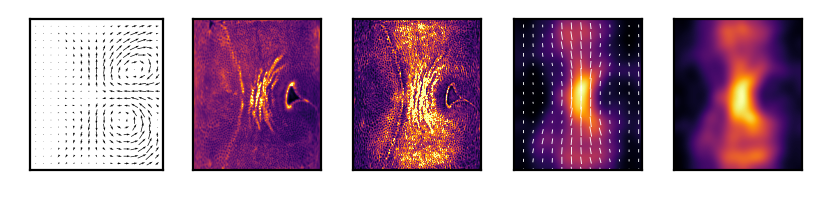

In [14]:
from utils.plot_utils import *

#Origin=lower convention! Remember this
plt.rcParams['image.cmap'] = 'inferno'
plt.rcParams['image.origin'] = 'lower'


fig, ax = plt.subplots(1, 5, dpi=200, figsize=(5, 1))

datadir = '../data/WT/ECad-GFP'
df = pd.read_csv(os.path.join(datadir, 'dynamic_index.csv'))
eID = df.embryoID.unique()[2]

vels = np.load(os.path.join(datadir, str(eID), 'velocity2D.npy'), mmap_mode='r')
raws = np.load(os.path.join(datadir, str(eID), 'raw2D.npy'), mmap_mode='r')
cyts = np.load(os.path.join(datadir, str(eID), 'cyt2D.npy'), mmap_mode='r')
tens = np.load(os.path.join(datadir, str(eID), 'tensor2D.npy'), mmap_mode='r')

print(np.max(raws), np.min(raws), np.median(raws))
print(np.max(cyts), np.min(cyts), np.median(cyts))

tt = 40
plot_vector2D(ax[0], vels[tt], skip=12)
color_2D(ax[1], raws[tt], vmax_std=10)
color_2D(ax[2], cyts[tt], vmax_std=3)
plot_tensor2D(ax[3], tens[tt, :], skip=15)
color_2D(ax[4], gaussian_filter(cyts[tt], sigma=8))

# Torch data interface to dynamic atlas

In [47]:
from dataset import *
from torchvision.transforms import Compose
transform=Compose([Reshape2DField(), ToTensor()])
cad = AtlasDataset('WT', 'ECad-GFP', 'tensor2D', transform=transform)
sqh = AtlasDataset('WT', 'sqh-mCherry', 'tensor2D', transform=transform)
vel = AtlasDataset('WT', 'ECad-GFP', 'velocity2D', transform=transform)

runt = AtlasDataset('WT', 'Runt', 'cyt2D', transform=transform)
vel = AtlasDataset('WT', 'Runt', 'velocity2D', transform=transform)

#hist = AtlasDataset('WT', 'histone-RFP', 'raw2D', transform=transform)
#vel = AtlasDataset('WT', 'histone-RFP', 'velocity2D', transform=transform)

print(len(runt), len(vel))

#dataset = AlignedDataset([sqh, cad, vel], ['sqh', 'cad', 'vel'])
dataset = AlignedDataset([runt, vel], ['runt', 'vel'])

batch = dataset[5]
for key in batch:
    try:
        print(key, batch[key].shape)
    except:
        print(key, batch[key])


dataset.df

100%|██████████| 6/6 [00:00<00:00, 614.51it/s]

498 498
embryo torch.Size([])
time torch.Size([])
genotype WT
runt torch.Size([1, 236, 200])
vel torch.Size([2, 236, 200])


,index_runt,embryoID,time,index_vel
0,0,202001150004,1.000000,0
1,1,202001150004,2.000000,1
2,2,202001150004,3.000000,2
3,3,202001150004,4.000000,3
4,4,202001150004,5.000000,4
...,...,...,...,...
493,493,202001141943,79.609360,493
494,494,202001141943,81.183102,494
495,495,202001141943,82.853797,495
496,496,202001141943,84.638666,496


# Keep all of our processed data within Dynamic Atlas

This is the testing notebook, see atlas_processing.py for the full code

In [52]:
'''
Metadata processing
'''
from scipy.io import loadmat


def convert_matstruct_to_csv(savedir):
    data = loadmat(os.path.join(savedir, 'dynamic_queried_sample.mat'))
    info = {}

    info['folder'] = [ df.astype('S') for df in data['folders'][0]]
    info['tiff'] = [ df.astype('S') for df in data['names'][0]]
    info['embryoID'] = [ df.astype('S') for df in data['embryoIDs'][0]]
    df = pd.DataFrame(info)
    df['folder'] = df['folder'].apply(lambda x: x[0].decode('utf-8'))
    df['tiff'] = df['tiff'].apply(lambda x: x[0].decode('utf-8'))
    df['embryoID'] = df['embryoID'].apply(lambda x: x[0].decode('utf-8'))

    times = [ dt.flatten()[:-1] for dt in data['times'][0]]
    df['time'] = times
    df = df.explode('time').reset_index(drop=True)
    df['eIdx'] = df.groupby(['embryoID']).cumcount()
    
    df.to_csv(os.path.join(savedir, 'dynamic_index.csv'), index=False)
    return df

'''
Pulling and reformatting data from Atlas
'''

from scipy.interpolate import RectBivariateSpline

piv_geometry = loadmat('/project/vitelli/jonathan/REDO_fruitfly/flydrive.synology.me/minimalData/Atlas_Data/embryo_geometry/embryo_rectPIVscale_fundamentalForms.mat')
pix_geometry = loadmat('/project/vitelli/jonathan/REDO_fruitfly/flydrive.synology.me/minimalData/vitelli_sharing/pixel_coordinates.mat')
Xpiv, Ypiv = piv_geometry['X0'][0], piv_geometry['Y0'][:, 0]
Xpix, Ypix = pix_geometry['XX'][0], pix_geometry['YY'][:, 0]

def collect_velocity_fields(savedir):
    '''
    We are LOCKING IN to IJ ordering
    Spatial ordering is [ROWS, COLUMNS] or [Y, X]
    Channel ordering is [VY, VX] corresponding to the spatial ordering
    
    Remember this when visualizing and lifting to 3D space
    '''
    if not os.path.exists(os.path.join(savedir, 'dynamic_index.csv')):
        warnings.warn('Index does not exist, processing matstruct')
        convert_matstruct_to_csv(savedir)
        
    warnings.warn('Collecting flow fields')
    
    df =  pd.read_csv(os.path.join(savedir, 'dynamic_index.csv'))
    for folder in df.folder.unique():
        ss = df[df.folder == folder]
        eID = ss.embryoID.iloc[0]
        
        velo_dir = os.path.join(folder, 'PIV_filtered')
        vels = []
        for eIdx in sorted(ss.eIdx):
            velo = loadmat(os.path.join(velo_dir, 'VeloT_medfilt_%06d.mat' % (eIdx+1)),
                           variable_names=['VX', 'VY'])
            
            if velo['VX'].shape[0] == Xpiv.shape[0]:
                X = Xpiv
            else:
                X = np.linspace(Xpiv.min(), Xpiv.max(), velo['VX'].shape[0])
            if velo['VX'].shape[1] == Ypiv.shape[0]:
                Y = Ypiv
            else:
                Y = np.linspace(Ypiv.min(), Ypiv.max(), velo['VX'].shape[1])
            
            vx = RectBivariateSpline(X, Y, velo['VX'])(Xpix, Ypix).T
            vy = RectBivariateSpline(X, Y, velo['VY'])(Xpix, Ypix).T
            vels.append(np.stack([vx, vy]))
        vels = np.stack(vels)
        np.save(os.path.join(folder, 'velocity2D'), vels)
from skimage.morphology import erosion, dilation, disk
cell_size = 8
structure = disk(cell_size)

def cytosolic_normalize(frame):
    background = dilation(erosion(frame, structure), structure)
    normalized = (frame - background) / background
    normalized[background == 0] = 0.
    return normalized

from scipy import ndimage
from skimage import transform
import windowed_radon as wr

size = 21
theta = np.linspace(0, 180, 45, endpoint=False)
radon_matrix = wr.get_radon_tf_matrix(size, theta=theta)

#sigma_space = 7 for sqh_ecad_dataset
#sigma_space = 12 otherwise (for some reason)
def anisotropy_tensor(frame, 
                      sigma_space=7,
                      threshold=1.75,
                      target_shape=(len(Ypix), len(Xpix))):
    m_tensor = wr.windowed_radon(frame, radon_matrix, theta=theta*np.pi/180, threshold_mean=threshold,
                                 method='global_maximum', return_lines=False)
    m_smooth = wr.filter_field(m_tensor, ndimage.gaussian_filter, kwargs={'sigma': sigma_space})
    m_smooth = wr.filter_field(m_smooth, transform.resize, kwargs={'output_shape': target_shape})
    #Correction to the radon transform code
    #Off-diagonal components are off by factor of -1 based on painting to 3d embryo
    #The reason is that we're using the origin='lower' convention
    #This is equivalent to the transform y->-y on the anisotropy tensor
    m_smooth[..., 0, 1] *= -1
    m_smooth[..., 1, 0] *= -1 
    
    #COMMIT to [M_YY, M_YX], [M_XY, M_XX] ordering
    tmatrix = np.array([[0, 1], [1, 0]])
    m_smooth = np.einsum('ik,...kl,lj->...ij', tmatrix, m_smooth, tmatrix)
    #Reshape
    m_smooth = m_smooth.transpose(2, 3, 0, 1)
    return m_smooth
        
from PIL import Image
from skimage.transform import resize

def collect_anisotropy_tensor(savedir, **wr_kwargs):
    '''
    We are LOCKING IN to IJ ordering
    Spatial ordering is [ROWS, COLUMNS] or [Y, X]
    Channel ordering is [M_YY, M_YX, M_XY, M_XX], 
        which corresponds to the spatial ordering
    
    Remember this when visualizing and lifting to 3D space
    '''    
    if not os.path.exists(os.path.join(savedir, 'dynamic_index.csv')):
        warnings.warn('Index does not exist, processing matstruct')
        convert_matstruct_to_csv(savedir)
        
    warnings.warn('Collecting anisotropy tensors')
    
    df =  pd.read_csv(os.path.join(savedir, 'dynamic_index.csv'))
    for folder in df.folder.unique():
        ss = df[df.folder == folder]
        eID = ss.embryoID.iloc[0]
        tiff_fn = os.path.join(folder, ss.tiff.iloc[0])
        movie = Image.open(tiff_fn)
        frames = np.sort(ss.eIdx.values)
        print('Embryo: ', eID, movie.n_frames, len(frames))
        raws = []
        cyts = []
        tensors = []
        for fId in tqdm(frames):
            movie.seek(fId)
            raw = np.array(movie)
            cyt = cytosolic_normalize(raw)
            
            tensor = anisotropy_tensor(cyt, **wr_kwargs)
            
            raws.append(raw)
            cyts.append(cyt)
            tensors.append(tensor)
        
        raws = np.stack(raws).astype(float)
        cyts = np.stack(cyts)
        tensors = np.stack(tensors)
        
        raws /= np.median(raws, axis=(1, 2), keepdims=True)
        cyts /= np.median(cyts, axis=(1, 2), keepdims=True)
        
        raws = resize(raws, [raws.shape[0], *tensors.shape[-2:]])
        cyts = resize(cyts, [cyts.shape[0], *tensors.shape[-2:]])
        
        np.save(os.path.join(folder, 'raw2D'), raws)
        np.save(os.path.join(folder, 'cyt2D'), cyts)
        np.save(os.path.join(folder, 'tensor2D'), tensors)
                
'''
3D embryo geometry handling
'''

emb_geometry = loadmat('../../MLData/embryo_geometry/embryo_3D_geometry.mat')
AP_space = emb_geometry['X'][0]
DV_space = emb_geometry['Y'][:, 0]
Z_AP = emb_geometry['Z'][0]
Phi_AP = emb_geometry['Phi'][::-1, 0]

z_emb = emb_geometry['z'][:, 0]
phi_emb = emb_geometry['ph'][:, 0]

e1 = emb_geometry['e2']
e2 = emb_geometry['e1']
Ei = np.stack([e1, e2], axis=-1).transpose(1, 2, 0)

def push_to_embryo_surface(savedir):
    if not os.path.exists(os.path.join(savedir, 'dynamic_index.csv')):
        warnings.warn('Index does not exist, processing matstruct')
        convert_matstruct_to_csv(savedir)
        
    warnings.warn('Pushing fields to embryo surface')
    
    df =  pd.read_csv(os.path.join(savedir, 'dynamic_index.csv'))
    for folder in df.folder.unique():
        ss = df[df.folder == folder]
        eID = ss.embryoID.iloc[0]
        files = glob.glob(os.path.join(savedir, str(eID)+'*2D.npy'))
        for file in files:
            data = np.load(file, mmap_mode='r')
            nTps = data.shape[0]
            data_emb = []
            for tt in tqdm(range(nTps)):
                frame = data[tt]
                header_shape = frame.shape[:-2]
                frame = frame.reshape([-1, *frame.shape[-2:]])

                f_APDV = np.stack([
                    RectBivariateSpline(Ypix, Xpix, frame[i])(DV_space, AP_space)
                    for i in range(frame.shape[0])])
                #We have to reverse the y axis here because RectBivariateSpline requires increasing order points
                f_emb = np.stack([
                    RectBivariateSpline(Phi_AP, Z_AP, f_APDV[i, ::-1])(phi_emb, z_emb, grid=False)
                    for i in range(frame.shape[0])])
                
                #Now convert using embryo surface basis vectors
                f_emb = f_emb.reshape([*header_shape, -1])
                
                if len(header_shape) == 1:
                    #Transforms like a vector
                    f_emb = np.einsum('ijv,jv->iv', Ei, f_emb)
                elif len(header_shape) == 2:
                    #Transforms like a tensor
                    f_emb = np.einsum('ikv,klv,jlv->ijv', Ei, f_emb, Ei)
                
                data_emb.append(f_emb)
                    
            data_emb = np.stack(data_emb)
            np.save(file[:-6]+'3D.npy', data_emb)
            
#savedir = '/project/vitelli/jonathan/REDO_fruitfly/MLData/WT/cad'
#savedir = '/project/vitelli/jonathan/REDO_fruitfly/MLData/WT/sqh'
#convert_matstruct_to_csv(savedir)
#collect_velocity_fields(savedir)
#collect_anisotropy_tensor(savedir)
#push_to_embryo_surface(savedir)

/project/vitelli/jonathan/REDO_fruitfly/src/atlas_processing/windowed_radon.py:300: RuntimeWarning: divide by zero encountered in true_divide
  line_weights = 1/(2*np.sqrt(e_len**2-(delta)**2))


In [53]:
def collect_pivlab_fields(savedir):
    '''
    We are LOCKING IN to IJ ordering
    Spatial ordering is [ROWS, COLUMNS] or [Y, X]
    Channel ordering is [VY, VX] corresponding to the spatial ordering
    
    Remember this when visualizing and lifting to 3D space
    '''
    if not os.path.exists(os.path.join(savedir, 'dynamic_index.csv')):
        warnings.warn('Index does not exist, processing matstruct')
        convert_matstruct_to_csv(savedir)
        
    warnings.warn('Collecting PIVlab flow fields')
    
    df =  pd.read_csv(os.path.join(savedir, 'dynamic_index.csv'))
    for folder in df.folder.unique():
        ss = df[df.folder == folder]
        eID = ss.embryoID.iloc[0]
        
        info_dir = os.path.join(folder, 'PIVlab')
        velo_dir = os.path.join(folder, 'PIVlab_filtered')
        vels = []
        for eIdx in sorted(ss.eIdx):
            info = loadmat(os.path.join(info_dir, 'VeloT_fine_%06d.mat' % (eIdx+1)),
                           variable_names=['X0', 'Y0'])
            velo = loadmat(os.path.join(velo_dir, 'VeloT_medfilt_fine_%06d.mat' % (eIdx+1)),
                           variable_names=['VX', 'VY'])
            #print(info['X0'][:, 0], info['Y0'][0], info['X0'].shape, velo['VX'].shape)

            vx = RectBivariateSpline(info['X0'][:, 0], info['Y0'][0], velo['VY'])(Xpix, Ypix).T
            vy = RectBivariateSpline(info['X0'][:, 0], info['Y0'][0], velo['VX'])(Xpix, Ypix).T
            vels.append(np.stack([vx, vy]))
        vels = np.stack(vels)
        np.save(os.path.join(folder, 'pivlab2D'), vels)

In [55]:
savedirs = [
    'WT/ECad-GFP',
    'WT/sqh-mCherry',
    'WT/moesin-GFP',
    'WT/Bazooka-GFP',
    'WT/Runt',
    'WT/Even_Skipped',
]

for savedir in savedirs:
    path = os.path.join('../../MLData', savedir)
    #df = convert_matstruct_to_csv(os.path.join('../../MLData', savedir))
    print(savedir, len(df))
    collect_velocity_fields(path)
    #collect_pivlab_fields(path)
    #collect_anisotropy_tensor(savedir)
    #push_to_embryo_surface(savedir)


WT/ECad-GFP 468


/project/vitelli/ml_venv/lib/python3.7/site-packages/ipykernel_launcher.py:50: UserWarning: Collecting flow fields


WT/sqh-mCherry 468
WT/moesin-GFP 468
WT/Bazooka-GFP 468
WT/Runt 468
WT/Even_Skipped 468


In [9]:
savedirs = [
    'MLData/Even-Skipped[r13]/Spaghetti_Squash-GFP',
    'MLData/TollRM9/Spaghetti_Squash-GFP',
    #'MLData/twistMinus/sqhGFP',
    'MLData/optoRhoGEF2_sqhCherry/headIllumination',
    'MLData/optoRhoGEF2_sqhCherry/singlePlaneIllumination'
]

for savedir in savedirs:
    df = convert_matstruct_to_csv(savedir)
    print(savedir, len(df))
    #collect_velocity_fields(savedir)
    collect_anisotropy_tensor(savedir)
    #push_to_embryo_surface(savedir)


MLData/Even-Skipped[r13]/Spaghetti_Squash-GFP 279


/project/vitelli/ml_venv/lib/python3.7/site-packages/ipykernel_launcher.py:125: UserWarning: Collecting anisotropy tensors


Embryo:  202101231300 60 59


100%|██████████| 59/59 [06:18<00:00,  6.41s/it]


Embryo:  202107071520 67 66


 76%|███████▌  | 50/66 [05:20<01:42,  6.42s/it]/project/vitelli/ml_venv/lib/python3.7/site-packages/ipykernel_launcher.py:73: RuntimeWarning: divide by zero encountered in true_divide
/project/vitelli/ml_venv/lib/python3.7/site-packages/ipykernel_launcher.py:73: RuntimeWarning: invalid value encountered in true_divide
100%|██████████| 66/66 [07:03<00:00,  6.41s/it]


Embryo:  202107071645 70 69


100%|██████████| 69/69 [07:21<00:00,  6.40s/it]


Embryo:  [DEPRECATED] 202103141755 38 37


100%|██████████| 37/37 [03:57<00:00,  6.41s/it]


Embryo:  [DEPRECATED] 202103142135 49 48


100%|██████████| 48/48 [05:07<00:00,  6.41s/it]


MLData/TollRM9/Spaghetti_Squash-GFP 71
Embryo:  202101121810 72 71


100%|██████████| 71/71 [07:34<00:00,  6.40s/it]


MLData/optoRhoGEF2_sqhCherry/headIllumination 275
Embryo:  202011241330 40 39


100%|██████████| 39/39 [04:09<00:00,  6.39s/it]


Embryo:  202102241100 60 59


100%|██████████| 59/59 [06:19<00:00,  6.44s/it]


Embryo:  202102241215 60 59


100%|██████████| 59/59 [06:18<00:00,  6.41s/it]


Embryo:  202102250915 60 59


100%|██████████| 59/59 [06:18<00:00,  6.42s/it]


Embryo:  202102251100 60 59


100%|██████████| 59/59 [06:19<00:00,  6.42s/it]


MLData/optoRhoGEF2_sqhCherry/singlePlaneIllumination 116
Embryo:  202011251120 40 39


100%|██████████| 39/39 [04:09<00:00,  6.40s/it]


Embryo:  202011251415 39 38


100%|██████████| 38/38 [04:03<00:00,  6.41s/it]


Embryo:  202011251450 40 39


100%|██████████| 39/39 [04:10<00:00,  6.41s/it]
